In [20]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import scipy.stats as stats

with open('data_proc.txt') as f:
    s = f.readlines()

s0 = [re.split(r'(?<=\d)}, {', user.strip('[{').strip('}]')) for user in s]
s1 = [[re.split(r',  (?=[\d\[])', session.lstrip(' ').rstrip('}]\n')) for session in user] for user in s0]
s2 = [[[el if i != 1 else re.split(r',  ""}, { ', el.strip('[{ ').strip(',  ""}]')) for i, el in enumerate(session)] for session in user] for user in s1]
s3 = [[[int(el) if i != 1 else np.sum([int(el2) for el2 in el if el2 != ''], dtype=int) for i, el in enumerate(session)] for session in user] for user in s2]
s_for_df = [[el for el in session] for user in s3 for session in user]

l = [len(u) for u in s3]
u_ids = [i for i in range(len(l)) for j in range(l[i])]

df_23 = pd.DataFrame(s_for_df[:49893])
df_22 = pd.DataFrame(s_for_df[49893:]).drop([22], axis=1)

df_23['user_id'] = u_ids[:49893]
df_22['user_id'] = u_ids[49893:]

In [21]:
df_23 = df_23[(df_23.T != 0).any()]

In [22]:
df_23.head(10)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,user_id
1,0,0,0,1669046400000,0,0,0,2674000,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1669050000000,0,0,0,7208000,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1669053600000,0,0,0,7203000,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,12,0,1669057200000,0,0,0,7203000,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,4,0,1669060800000,0,0,0,4266000,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,1669046400000,0,0,0,2674000,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,1669050000000,0,0,0,7208000,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,1669053600000,0,0,0,7203000,0,0,...,0,0,0,0,0,0,0,0,0,1
10,1,12,0,1669057200000,0,0,0,7203000,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
features = list(df_23.columns)

# Print the list of features
print(features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 'user_id']


In [24]:
df_23.columns = ['0', '1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'user_id']

In [25]:
check_correlation = df_23.drop(["user_id"],axis=1)

def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_corr.style.background_gradient(cmap='coolwarm')
    display(df_corr)
    df_corr = df_corr.dropna(axis=1, how='all')
    df_corr = df_corr.dropna(axis=0, how='all')
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

df = trimm_correlated(check_correlation, 0.9)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.000000,0.363191,0.013346,-0.014659,NaN,-0.002802,NaN,0.204074,0.016158,NaN,...,NaN,0.006777,0.013404,0.002862,-0.073445,0.010227,NaN,0.008645,-0.034573,0.029279
1,0.363191,1.000000,0.399035,0.054038,NaN,-0.001134,NaN,0.087552,0.049861,NaN,...,NaN,0.018516,0.399134,0.027276,0.017264,0.169614,NaN,0.022618,0.049840,0.194907
2,0.013346,0.399035,1.000000,0.122016,NaN,-0.000165,NaN,-0.009091,0.040569,NaN,...,NaN,0.403641,0.999806,0.043893,0.156969,0.521163,NaN,0.707472,0.090380,0.232322
3,-0.014659,0.054038,0.122016,1.000000,NaN,-0.000654,NaN,0.694539,0.005406,NaN,...,NaN,0.000984,0.122053,-0.003769,0.034102,0.112969,NaN,0.075927,0.042331,0.124849
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.002802,-0.001134,-0.000165,-0.000654,NaN,1.000000,NaN,0.005725,-0.000105,NaN,...,NaN,-0.000039,-0.000164,-0.000116,0.030458,0.031995,NaN,-0.000117,0.037478,0.008191
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.204074,0.087552,-0.009091,0.694539,NaN,0.005725,NaN,1.000000,-0.005852,NaN,...,NaN,-0.001136,-0.009068,-0.006956,-0.026872,-0.012020,NaN,-0.006455,-0.003756,-0.004384
8,0.016158,0.049861,0.040569,0.005406,NaN,-0.000105,NaN,-0.005852,1.000000,NaN,...,NaN,0.002216,0.040579,0.404280,0.147306,0.474651,NaN,0.002854,0.210422,0.495139
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df['user_id'] = df_23['user_id']

<ipython-input-26-4f0a8b33af9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['user_id'] = df_23['user_id']


In [27]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns).drop(["user_id"],axis=1).dropna()

In [28]:
data = df

X = df_scaled

kmeans = KMeans(n_clusters=2)

kmeans.fit(X)

labels = kmeans.predict(X)

data['cluster'] = labels

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-28-6f1b12129ee9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = labels


In [29]:
grouped_data = data.groupby('user_id')['cluster'].mean().reset_index()

grouped_data = grouped_data.rename(columns={'cluster': 'mean_cluster'})

print(grouped_data)

     user_id  mean_cluster
0          0      1.000000
1          1      0.833333
2          2      0.833333
3          3      0.961538
4          4      0.961538
..       ...           ...
366      366      0.666667
367      367      0.000000
368      368      0.000000
369      369      0.000000
370      370      0.000000

[371 rows x 2 columns]


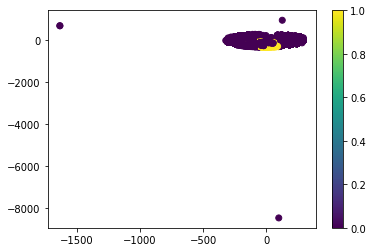

In [30]:
y = labels

#X.columns = X.columns.astype(str)
# Initialize the t-SNE model with default hyperparameters
tsne = TSNE(perplexity=2.0)

# Fit the t-SNE model to the data and transform the data into a low-dimensional space
X_tsne = tsne.fit_transform(X)

# Visualize the data in a scatter plot
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='viridis')
plt.colorbar()
plt.show()

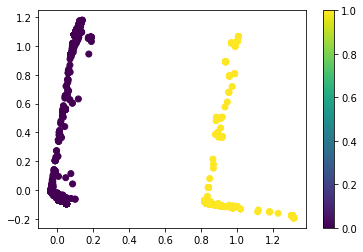

In [31]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')
plt.colorbar()
plt.show()

In [32]:
data

,0,1,2,3,5,7,8,10,11,14,16,17,18,20,21,22,user_id,cluster
1,0,0,0,1669046400000,0,2674000,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1669050000000,0,7208000,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1669053600000,0,7203000,0,0,0,0,0,0,0,0,0,0,0,1
4,1,12,0,1669057200000,0,7203000,0,0,0,0,0,0,0,0,0,0,0,1
5,1,4,0,1669060800000,0,4266000,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,370,0
49889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,370,0
49890,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,370,0
49891,1,4,1,0,0,0,38,0,0,2000,0,2126000,542000,0,3285000,1882000,370,0


In [33]:
grouped = data.groupby('user_id')['cluster'].sum()

result_df = pd.DataFrame({
    'id': grouped.index,
    'подозрительные сессии': grouped.values,
    'обычные сессии': data.groupby('user_id')['cluster'].size().values - grouped.values
})

result_df

,id,подозрительные сессии,обычные сессии
0,0,5,0
1,1,5,1
2,2,5,1
3,3,25,1
4,4,25,1
...,...,...,...
366,366,2,1
367,367,0,168
368,368,0,168
369,369,0,2


In [38]:
grouped = data.groupby('user_id')['cluster'].sum()

result_df = pd.DataFrame({
    'id': grouped.index,
    'процент подозрительных сессий': grouped.values / data.groupby('user_id')['cluster'].size().values
})

result_df

,id,процент подозрительных сессий
0,0,1.000000
1,1,0.833333
2,2,0.833333
3,3,0.961538
4,4,0.961538
...,...,...
366,366,0.666667
367,367,0.000000
368,368,0.000000
369,369,0.000000


(array([311.,   0.,   0.,   0.,   0.,   2.,   3.,   2.,  21.,  32.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

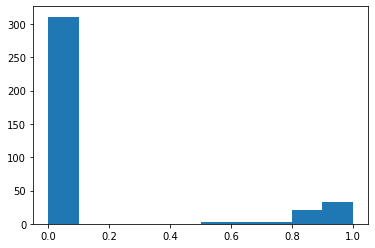

In [39]:
import matplotlib.pyplot as plt

plt.hist(result_df['процент подозрительных сессий'])